In [2]:
import sys
sys.path.append("../")

from smc.utils import ProgressBar, gaussian_kernel
from models.samplers.ising import ExternalFieldIsingModel as IsingSMC
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

The $D$-dimensional Ising model with interation $\alpha$ and magnetic moment $\mu$ is given by

$$ \pi(M \,|\,\alpha, \mu) \propto \exp\Big(\frac{\alpha M^2 + \mu M}{D}\Big)$$

Where $M = \sum_d^D=\sigma_d $ is the total magnetisation of the system 

In [12]:
np.random.seed(1337)
dimension = 25
alpha = 0.75
magnetic_moment = 1.0
Ising = IsingSMC(dimension, alpha, magnetic_moment)

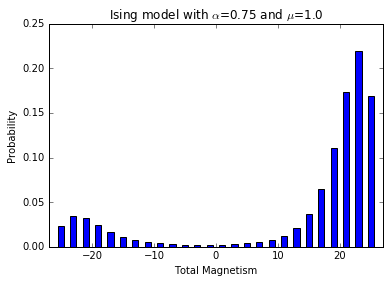

In [13]:
probabilities, magnetism = Ising._true_probabilities((1.0,))
plt.bar(magnetism-0.5, probabilities, width=1.0)
plt.xlim(-(dimension+2.0), dimension+2.0)
plt.xlabel('Total Magnetism')
plt.ylabel('Probability')
plt.title(r'Ising model with $\alpha$={} and $\mu$={}'.format(alpha, magnetic_moment))
plt.show()

In this notebook we compare different numerical methods for sampling from the Ising distribution. We consider the following sampling methods

- Sequential Monte Carlo
- SMC with adaptive resampling
- Annealed importance sampling (no resampling)
- Multilevel sampling (no weights, no resampling)

We use each method to draw 100 samples from an Ising model with $D=25$, $\alpha=0.75$ and $\mu = 1.0$. We compare the resulting empirical measure to the target distribution using the total variation distance (based on total magnetism). We consider the following parameter settings

- Number of steps: 5, 10, 15
- Number of gibbs scans per step: 2, 6
- Path selection: Linear, L2 optimal, and adaptive

We perform 500 simulations for each sampling method using each parameter setting

In [14]:
path_lens = [5, 10, 15]
steps = [2, 6]
N = 100
iters = 500

## Linear path

In [15]:
linear_results, linear_path = ising_multilevel_comparison(Ising, N, path_lens, steps, 'linear')

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 6001.6 seconds.


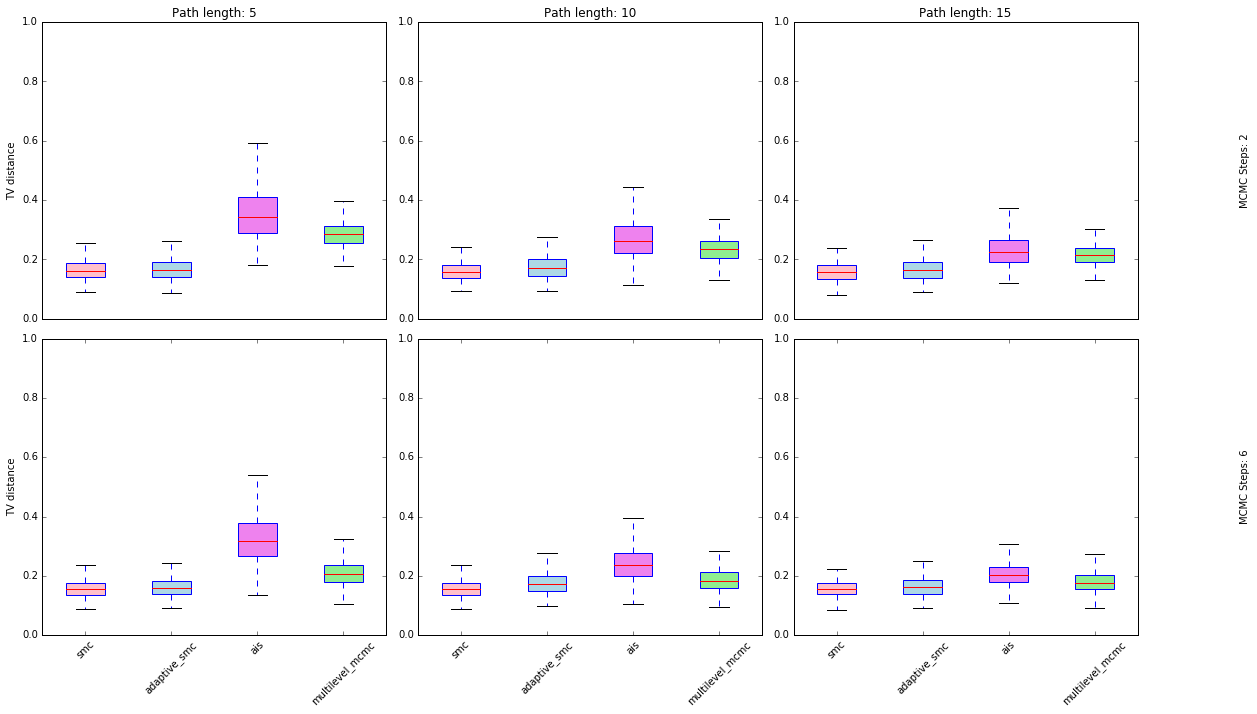

In [16]:
fname = 'plots/multilevel_ising/ising_{}_{}_{}_comparison_linear_path.png'.format(alpha, magnetic_moment, dimension)
plot_ising_results(linear_results, fname)

## Optimal Path

Some path lengths and associated c's

In [17]:
optimal_results, optimal_path = ising_multilevel_comparison(Ising, N, path_lens, steps, 'optimal')

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 5821.9 seconds.


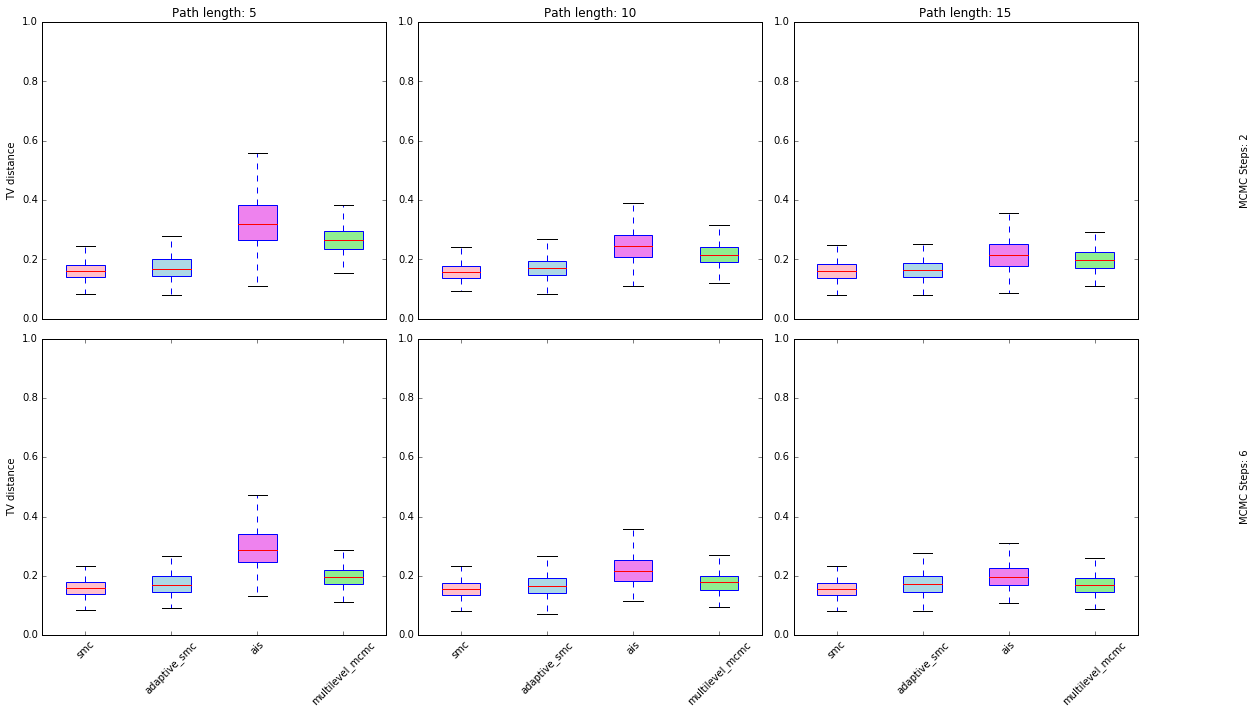

In [18]:
fname = 'plots/multilevel_ising/ising_{}_{}_{}_comparison_optimal_path.png'.format(alpha, magnetic_moment, dimension)
plot_ising_results(optimal_results, fname)

## Adaptive Path

In [19]:
adaptive_results, adaptive_path = ising_multilevel_comparison(Ising, N, path_lens, steps, 'adaptive')

% complete:  1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88 91 94 97 100 
Elapsed time: 5835.0 seconds.


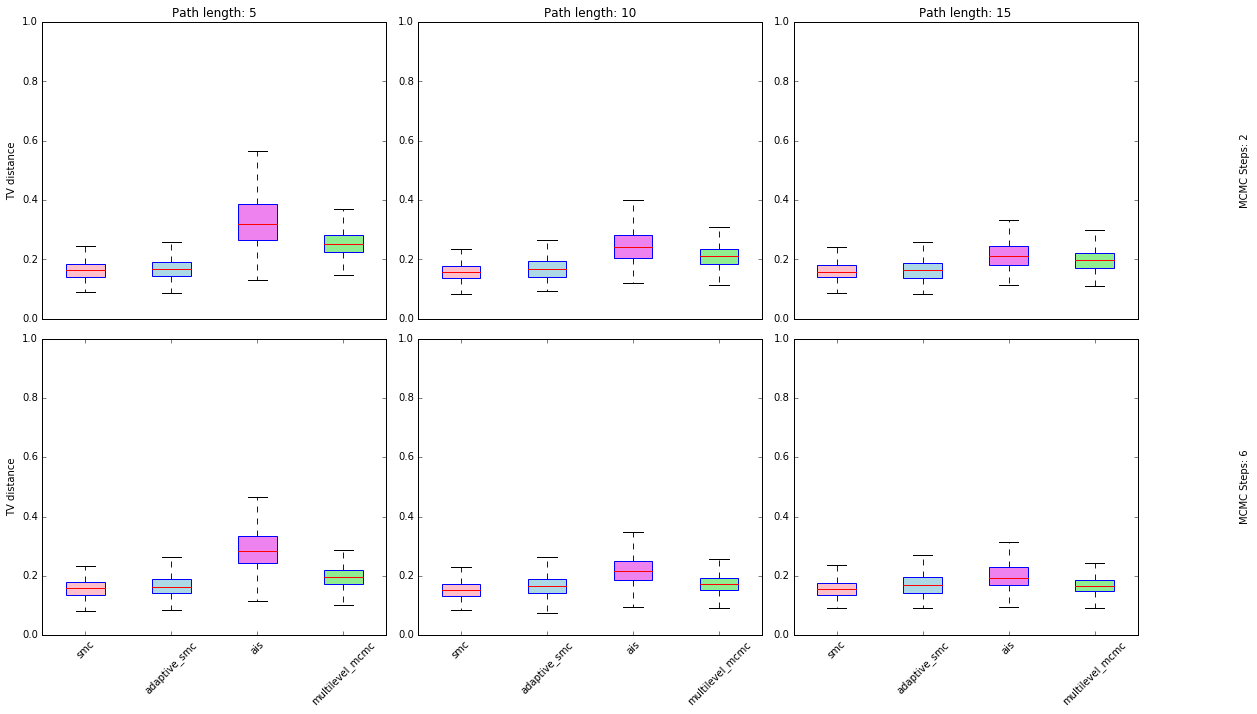

In [20]:
fname = 'plots/multilevel_ising/ising_{}_{}_{}_comparison_adaptive_path.png'.format(alpha, magnetic_moment, dimension)
plot_ising_results(adaptive_results, fname)

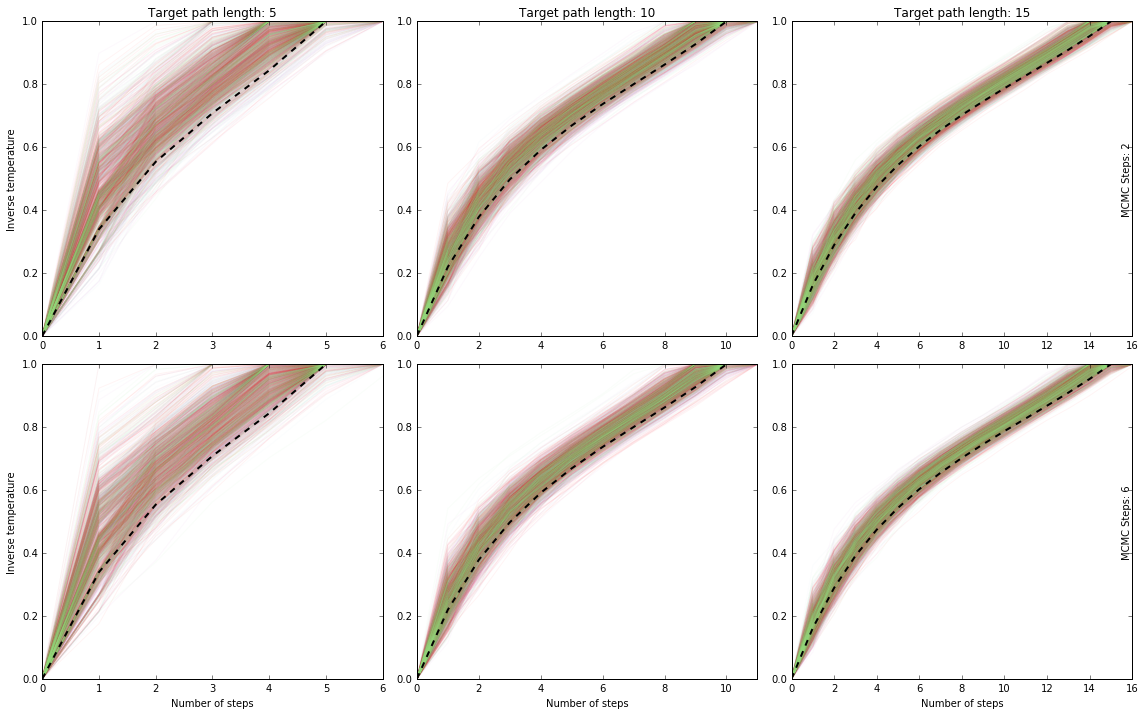

In [21]:
i = 0
methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']
colors = ['lightblue', 'orchid', 'red', 'lightgreen']
for row, step in enumerate(steps):
    for col, path_len in enumerate(path_lens):

        # fake an mcmc estimate       
        i+=1
        plt.subplot(len(steps), len(path_lens), i)
        
        for color, method in zip(colors, methods):
            for path in adaptive_path[(path_len, step)][method]:
                plt.plot(path, color=color, alpha=1.0/iters**0.5)
                
        target_ess = get_optimal_ess(Ising, path_len+1)
        path = np.array(get_path(Ising, target_ess)).flatten()
        
        plt.plot(path, color='k', lw=2, ls='--')
        
        plt.ylim(0, 1.0)
        plt.xlim(0, path_len+1)
        
        if row==0:
            plt.title('Target path length: {}'.format(path_len))
            
        if col==0:
            plt.ylabel('Inverse temperature')
            
        if row==(len(steps)-1):
            plt.xlabel('Number of steps')
            
        if col==(len(path_lens)-1):
            plt.text(path_lens[-1]+0.75, 0.5, 'MCMC Steps: {}'.format(step),
                     horizontalalignment='center',
                     verticalalignment='center',
                     rotation='vertical')
            
plt.tight_layout()
plt.savefig('plots/multilevel_ising/ising_{}_{}_{}_adaptive_path_comparison.png'.format(alpha, magnetic_moment, dimension))
plt.show()

In [3]:
def plot_ising_results(results, fname, methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']):
    
    i = 0
    plt.rcParams['figure.figsize'] = 16, 10
    colors = ['pink', 'lightblue', 'violet', 'lightgreen']
    
    for row, step in enumerate(steps):
        for col, path_len in enumerate(path_lens):

            # fake an mcmc estimate      
            numbers= [results[(path_len, step)][method] for method in methods]

            i+=1
            plt.subplot(len(steps), len(path_lens), i)

            # set colors
            bplot = plt.boxplot(numbers, patch_artist=True, showfliers=False)
            for patch, color in zip(bplot['boxes'], colors):
                patch.set_facecolor(color)


            plt.ylim(0, 1.0)
            plt.xticks([], [])

            if row==0:
                plt.title('Path length: {}'.format(path_len))            

            if col==0:
                plt.ylabel('TV distance')

            if row==(len(steps)-1):
                plt.xticks(range(1,len(methods)+1), methods, rotation=45)

            if col==(len(path_lens)-1):
                plt.text(5.75, 0.5, 'MCMC Steps: {}'.format(step),
                         horizontalalignment='center',
                         verticalalignment='center',
                         rotation='vertical')

    plt.tight_layout()
    plt.savefig(fname)
    plt.show()
    
def get_step_size(ising, beta, target_ess):
    """ returns the step size needed to ensure that the target ess is achieved"""
    
    # procomputation
    probabilities, magnetism = ising._true_probabilities((beta,))
    energy = (ising.alpha*magnetism**2 + ising.magnetic*magnetism)/ising.dimension

    ess = lambda delta: np.dot(probabilities, np.exp(delta*energy))**2 /\
        np.dot(probabilities, np.exp(2*delta*energy)) - target_ess
        
    from scipy.optimize import brentq
    
    delta = 1.0-beta
    
    if ess(delta)<0:
        delta = brentq(ess, 0, 1.0-beta)
    
    return delta

def get_path(ising, target_ess):
    """returns a path using the target_ess"""
    path = [(0.0,)]
    while path[-1][0]< 1:
        
        beta = path[-1][0]
        delta = get_step_size(ising, beta, target_ess)
        path.append((beta+delta,))
        
    return path

def get_optimal_ess(ising, target_length):
    """ returns the optimal ess for a given path length """
    
    cost = lambda (ess): len(get_path(ising, ess))-target_length

    # start the optimizer
    upper = 1.0 # too many steps
    lower = 0.0 # too few steps
    max_iters = 100
    i = 0

    while i<max_iters:
        i+=1

        current = (upper+lower)/2.0
        current_cost = cost(current)

        if current_cost<=0:
            lower = current
        elif current_cost>0:
            upper = current
            
    return lower

def ising_multilevel_comparison(model, N, path_lens, steps, path_type, 
                                methods = ['smc', 'adaptive_smc', 'ais', 'multilevel_mcmc']):
    """ does a multilevel model comparison for the specified path t"""
    results = {}
    paths = {}

    pb = ProgressBar(iters*len(methods)*len(path_lens)*len(steps))

    for path_len in path_lens:
        
        # init the path
        if path_type == 'linear':
            path = [(beta,) for beta in np.linspace(0,1,path_len+1)]
        elif path_type ==  'optimal':
            target_ess = get_optimal_ess(model, path_len+1)
            path = get_path(model, target_ess)
        elif path_type == 'adaptive':
            ess = get_optimal_ess(model, path_len+1)
        else:
            raise ValueError(""" path_type must be 'linear', 'optimal', or 'adaptive' """)
            
        # go through the different numbers of mcmc stesp
        for step in steps:       

            # init this dict
            results[(path_len, step)] = {}
            for method in methods:
                results[(path_len, step)][method]=[]
                
            # save the paths cause why not
            paths[(path_len, step)] = {}
            for method in methods:
                paths[(path_len, step)][method]=[]

            for i in range(iters):   

                # loop through the methods
                for method in methods:

                    # sample and estimate
                    if path_type=='adaptive':
                        output = model.adaptive_sampling(N, 
                                                         ess, 
                                                         method=method, 
                                                         save_all_samples=False, 
                                                         smc_kwargs={'kernel_steps':step}, 
                                                         verbose=False)
                        path = output[-1]
                        
                    else:                    
                        output = model.sampling(path, 
                                                N, 
                                                method=method, 
                                                save_all_samples=False, 
                                                smc_kwargs={'kernel_steps':step}, 
                                                verbose=False)
                        
                    tv = model._total_variation(output[0], output[1])

                    # record stuff 
                    results[(path_len, step)][method].append(tv)    
                    paths[(path_len, step)][method].append(np.array(path).flatten()) 
                    pb.increment()        
    pb.finish()
        
    return results, paths